In [1]:
from google.colab import files
train_file = files.upload()

Saving dreaddit-train.csv to dreaddit-train.csv


In [2]:
test_file = files.upload()

Saving dreaddit-test.csv to dreaddit-test.csv


In [3]:
import io
import pandas as pd
import numpy as np

In [4]:
train = pd.read_csv(io.BytesIO(train_file['dreaddit-train.csv']))
test = pd.read_csv(io.BytesIO(test_file['dreaddit-test.csv']))

In [5]:
full = pd.concat((train, test), sort=False).reset_index(drop=True)

In [6]:
df = full[['text', 'subreddit']].copy()
df.head(10)

,text,subreddit
0,"He said he had not felt that way before, sugge...",ptsd
1,"Hey there r/assistance, Not sure if this is th...",assistance
2,My mom then hit me with the newspaper and it s...,ptsd
3,"until i met my new boyfriend, he is amazing, h...",relationships
4,October is Domestic Violence Awareness Month a...,survivorsofabuse
5,I think he doesn't want to put in the effort f...,relationships
6,It was a big company so luckily I didn't have ...,domesticviolence
7,It cleared up and I was okay but. On Monday ...,anxiety
8,I actually give an assistant half my emergency...,relationships
9,I just feel like the street life has fucked my...,assistance


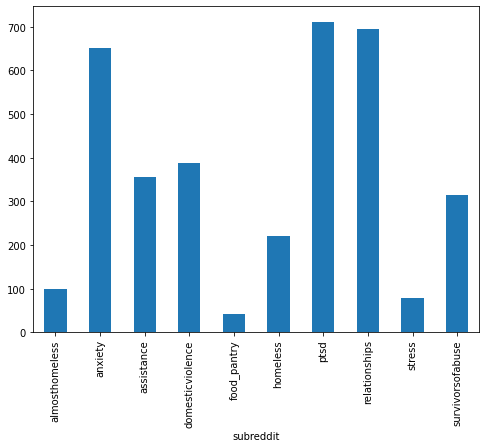

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

df.groupby('subreddit').text.count().plot.bar(ylim=0)
plt.show()

In [8]:
df['subreddit_id'] = df['subreddit'].factorize()[0]
df.head(10)

,text,subreddit,subreddit_id
0,"He said he had not felt that way before, sugge...",ptsd,0
1,"Hey there r/assistance, Not sure if this is th...",assistance,1
2,My mom then hit me with the newspaper and it s...,ptsd,0
3,"until i met my new boyfriend, he is amazing, h...",relationships,2
4,October is Domestic Violence Awareness Month a...,survivorsofabuse,3
5,I think he doesn't want to put in the effort f...,relationships,2
6,It was a big company so luckily I didn't have ...,domesticviolence,4
7,It cleared up and I was okay but. On Monday ...,anxiety,5
8,I actually give an assistant half my emergency...,relationships,2
9,I just feel like the street life has fucked my...,assistance,1


## Count the number of each category

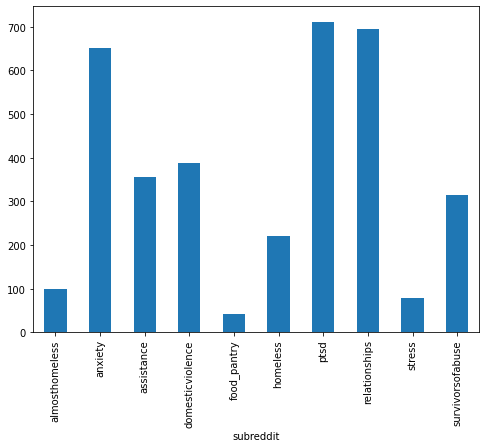

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

df.groupby('subreddit').text.count().plot.bar(ylim=0)
plt.show()

## Preprocessing

In [10]:
subreddit_id_df = df[['subreddit', 'subreddit_id']].drop_duplicates().sort_values('subreddit_id') # remove duplicate rows
subreddit_to_id = dict(subreddit_id_df.values)

subreddit_to_id = dict(subreddit_id_df.values)  # {'ptsd': 0, 'assistance': 1, ... , 'food_pantry': 10}
id_to_subreddit = dict(subreddit_id_df[['subreddit_id', 'subreddit']].values) # {0: 'ptsd', ... , 10: 'food_pantry'}

df.head()

,text,subreddit,subreddit_id
0,"He said he had not felt that way before, sugge...",ptsd,0
1,"Hey there r/assistance, Not sure if this is th...",assistance,1
2,My mom then hit me with the newspaper and it s...,ptsd,0
3,"until i met my new boyfriend, he is amazing, h...",relationships,2
4,October is Domestic Violence Awareness Month a...,survivorsofabuse,3


### Stopwords

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Preprocessing

In [12]:
import re
from string import punctuation

def lower(text):
  return text.lower()

def remove_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
  return text.translate(str.maketrans('','', punctuation))

def clean_text(text):
  text = lower(text)
  text = remove_stopwords(text)
  text = remove_punctuation(text)
  return text

# Apply function to columns
df['clean_text'] = df['text'].apply(clean_text)

### Lemmatization

In [13]:
nltk.download('omw-1.4')
nltk.download('wordnet')  # Calculate similarity between words
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()  # Headword extraction

def lemmatizer_words(text):
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['clean_text'] = df['clean_text'].apply(lambda text: lemmatizer_words(text))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
df.head()

,text,subreddit,subreddit_id,clean_text
0,"He said he had not felt that way before, sugge...",ptsd,0,said felt way before suggeted go rest trigger ...
1,"Hey there r/assistance, Not sure if this is th...",assistance,1,hey rassistance sure right place post this go ...
2,My mom then hit me with the newspaper and it s...,ptsd,0,mom hit newspaper shocked would this know like...
3,"until i met my new boyfriend, he is amazing, h...",relationships,2,met new boyfriend amazing kind sweet good stud...
4,October is Domestic Violence Awareness Month a...,survivorsofabuse,3,october domestic violence awareness month dome...


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words='english')

features = tfidf.fit_transform(df.clean_text).toarray()
labels = df.subreddit_id

features.shape

(3553, 4191)

In [16]:
from sklearn.feature_selection import chi2
N = 2

for subreddit, subreddit_id in sorted(subreddit_to_id.items()):
  features_chi2 = chi2(features, labels == subreddit_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n[ %s ]" %(subreddit))
  print(" * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print(" * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


[ almosthomeless ]
 * Most Correlated Unigrams are: penny, parttime
 * Most Correlated Bigrams are: going college, soon possible

[ anxiety ]
 * Most Correlated Unigrams are: anxious, anxiety
 * Most Correlated Bigrams are: make anxious, panic attack

[ assistance ]
 * Most Correlated Unigrams are: gofundme, url
 * Most Correlated Bigrams are: gofundme url, amazon wishlist

[ domesticviolence ]
 * Most Correlated Unigrams are: domestic, police
 * Most Correlated Bigrams are: called police, domestic violence

[ food_pantry ]
 * Most Correlated Unigrams are: supermarket, rice
 * Most Correlated Bigrams are: new job, food bank

[ homeless ]
 * Most Correlated Unigrams are: shelter, homeless
 * Most Correlated Bigrams are: ive homeless, homeless shelter

[ ptsd ]
 * Most Correlated Unigrams are: trauma, ptsd
 * Most Correlated Bigrams are: service dog, diagnosed ptsd

[ relationships ]
 * Most Correlated Unigrams are: relationship, tldr
 * Most Correlated Bigrams are: new year, tldr boyfr

### TfidfVectorizer 사용 O, CountVectorizer 사용 X

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state = 42)

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

predicted = lr.predict(X_test)

print(f"Accuracy: {lr.score(X_test, y_test)}")

Accuracy: 0.5298087739032621


### TfidfVectorizer 사용 X, CountVectorizer 사용 O

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['subreddit_id'], test_size=0.25, random_state = 42)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

predicted = lr.predict(X_test_tfidf)

print(f"Accuracy: {lr.score(X_test_tfidf, y_test)}")

Accuracy: 0.5298087739032621
